In [4]:
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import warnings 
warnings.filterwarnings('ignore')

In [5]:
movie_df = pd.read_csv('movie_features.csv', index_col = 0)

In [6]:
movie_df.head()

,Title,Domestic_Revenue,Worldwide_Revenue,Distributor,Opening_weekend_box,no_Theaters_open,Budget,Genre,Days_In_theaters,Running_Time(min),G,PG,PG_13,R,winter,spring,summer,fall_holiday,Genre Label
0,12 Years a Slave,56671993,187733202,Fox Searchlight Pictures,923715,19,20000000,"Biography,Drama,History",440,134,0,0,0,1,0,0,0,1,241
1,127 Hours,18335230,60738797,Fox Searchlight Pictures,264851,4,18000000,"Biography,Drama",422,94,0,0,0,1,0,0,0,1,235
2,13 Hours,52853219,69411370,Paramount Pictures,16194738,2389,50000000,"Action,Drama,Thriller,War",352,144,0,0,0,1,1,0,0,0,132
3,1917,159227644,384983987,Universal Pictures,576216,11,95000000,"Action,Drama,War",373,119,0,0,0,1,0,0,0,1,133
4,2 Guns,75612460,131940411,Universal Pictures,27059130,3025,61000000,"Action,Comedy,Crime,Thriller",152,109,0,0,0,1,0,0,1,0,91


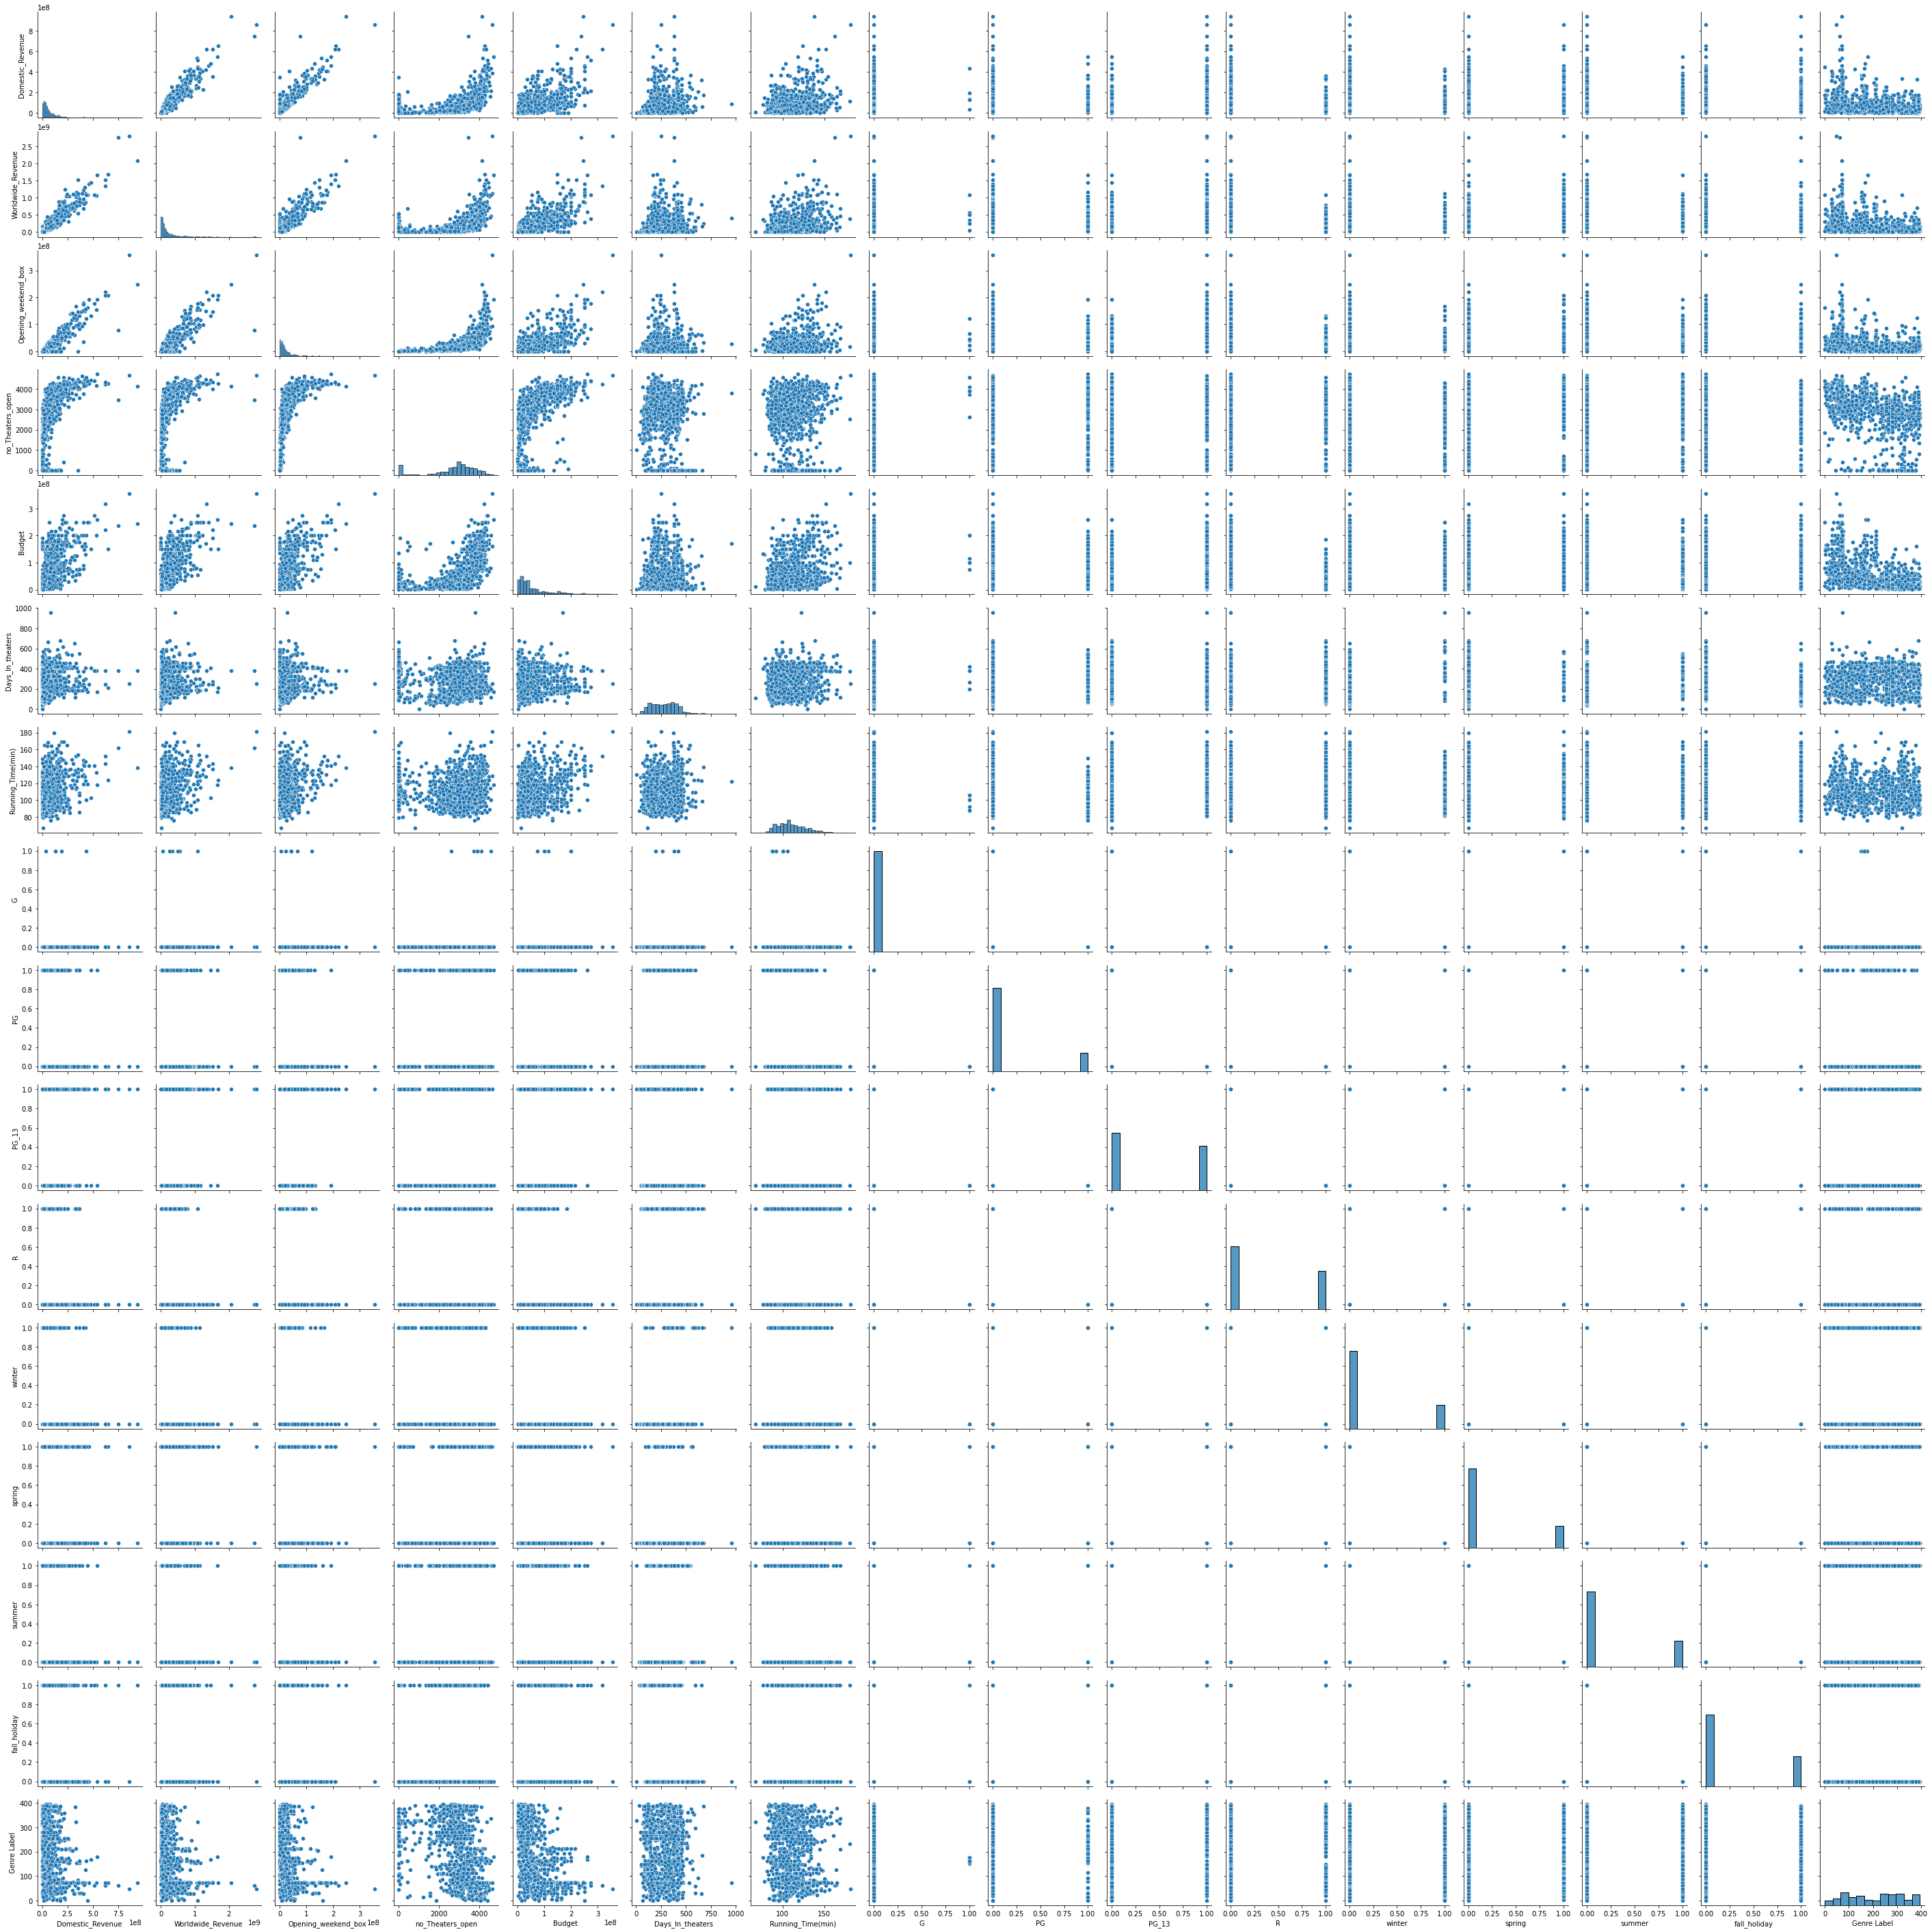

In [7]:
#Lets start by taking a look at a pairplot of all of our features
sns.pairplot(movie_df)


<AxesSubplot:xlabel='Budget', ylabel='Domestic_Revenue'>

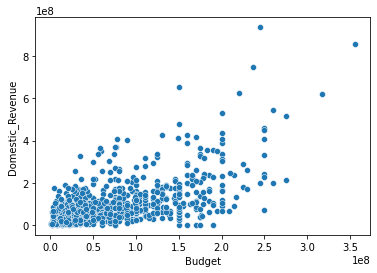

In [9]:
sns.scatterplot(x = 'Budget', y = 'Domestic_Revenue', data=movie_df)
#domestic box office revenue is going to be my target variable, so lets get a closer look at it. 
#The distribution is a bit skewed from the bulk of my films being low-mid budget

Text(0.5, 0, 'Total Domestic Gross')

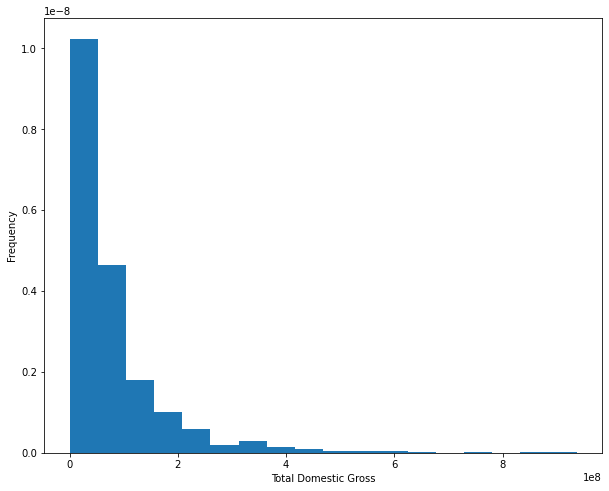

In [10]:
#lets get another look at domestic gross in a histogram
plt.figure(figsize=[10,8])
movie_df['Domestic_Revenue'].plot.hist(density=True, bins = 18)
plt.xlabel("Total Domestic Gross")

Text(0.5, 0, 'Total Domestic Gross(log)')

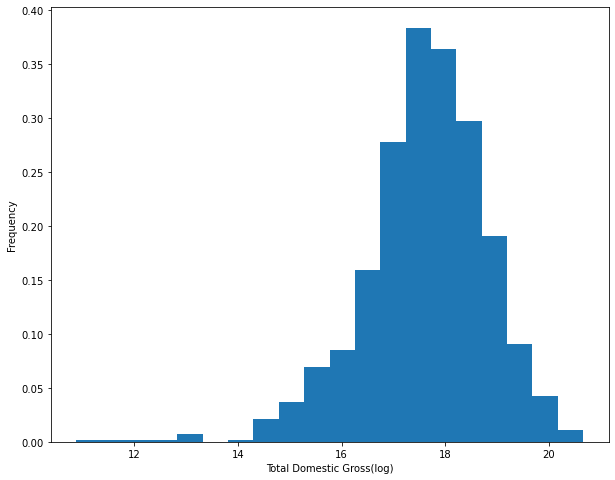

In [14]:
#once again we can see it is heavily weighted, lets get the log of domestic gross and see how that looks
plt.figure(figsize=[10,8])
np.log(movie_df['Domestic_Revenue']).plot.hist(density=True, bins = 20)
plt.xlabel("Total Domestic Gross(log)")

In [15]:
#That looks better so lets store that again as our (log) target variable
movie_df['dom_log_target'] = np.log(movie_df.Domestic_Revenue)

In [16]:
#lets see how we score before and after our log adjustment. This initial R**2 doesn't make any sense
X = movie_df.loc[:,['Budget', 'Opening_weekend_box']]
y = movie_df.loc[:,'Domestic_Revenue']

model = sm.OLS(y, X, data=movie_df)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:       Domestic_Revenue   R-squared (uncentered):                   3.074
Model:                            OLS   Adj. R-squared (uncentered):              3.077
Method:                 Least Squares   F-statistic:                             -855.2
Date:                Thu, 30 Sep 2021   Prob (F-statistic):                        1.00
Time:                        22:17:26   Log-Likelihood:                         -21788.
No. Observations:                1156   AIC:                                  4.358e+04
Df Residuals:                    1154   BIC:                                  4.359e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [17]:
#lets try that again with our target log
X = movie_df.loc[:,['Budget', 'Opening_weekend_box']]
y = movie_df.loc[:,'dom_log_target']

model = sm.OLS(y, X, data=movie_df)
results = model.fit()
print(results.summary())
#that looks better

                                 OLS Regression Results                                
Dep. Variable:         dom_log_target   R-squared (uncentered):                   0.552
Model:                            OLS   Adj. R-squared (uncentered):              0.551
Method:                 Least Squares   F-statistic:                              709.9
Date:                Thu, 30 Sep 2021   Prob (F-statistic):                   9.81e-202
Time:                        22:17:42   Log-Likelihood:                         -4495.3
No. Observations:                1156   AIC:                                      8995.
Df Residuals:                    1154   BIC:                                      9005.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [18]:
#This is my first model using just linear regression and a 5x kfold, lets run it through a different models and 
#see which ones give the best results, this score is across all of our features, so I will narrow them down from here
def run_models(X,y,kf):
       
    #Spliting the data into train, test and validation (%60 - %20 - %20)
    X, X_test, y, y_test = train_test_split(X, y, test_size = .2, random_state = 12)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .25, random_state = 12)

    #LinearReg
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred_lm = lm.predict(X_test)
    print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
    print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')
    print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')
    print(f'Linear Regression CV train : {cross_val_score(lm, X_train, y_train, cv=kf).mean():.3f}')
    print(f'Linear Regression MAE : {mean_absolute_error(y_test, y_pred_lm):.3f}')
    
    #Polynomial(2deg)
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)
    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    y_pred = lm_poly.predict(X_test_poly)
    print(f'Degree 2 Polynomial Regression train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
    print(f'Degree 2 Polynomial Regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
    print(f'Degree 2 Polynomial Regression test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')
    print(f'Degree 2 Polynomial CV train : {cross_val_score(lm_poly, X_train_poly, y_train, cv=kf).mean():.3f}')
    print(f'Degree 2 Polynomial Regression MAE : {mean_absolute_error(y_test, y_pred):.3f}')
    
    #Ridge
    alpha_ri = 10**np.linspace(-2,2,200)
    lm_ri = RidgeCV(alphas=alpha_ri, cv=kf)
    lm_ri.fit(X_train, y_train)
    lm_ri_mdl = Ridge(alpha = lm_ri.alpha_) 
    lm_ri_mdl.fit(X_train, y_train)
    y_pred_ri = lm_ri_mdl.predict(X_test)
    
    print(f'Ridge Regression train R^2: {lm_ri_mdl.score(X_train, y_train):.3f}')
    print(f'Ridge Regression val R^2: {lm_ri_mdl.score(X_val, y_val):.3f}')
    print(f'Ridge Regression test R^2: {lm_ri_mdl.score(X_test, y_test):.3f}')
    print(f'Ridge Regression CV train : {cross_val_score(lm_ri_mdl, X_train, y_train, cv=kf).mean():.3f}')
    print(f'Ridge Regression alpha : {lm_ri.alpha_:.3f}')
    print(f'Ridge Regression MAE : {mean_absolute_error(y_test, y_pred_ri):.3f}')
    
     #PolyRidge
    alpha_poly_ri = 10**np.linspace(-2,2,200)
    lm_poly_ri = RidgeCV(alphas=alpha_poly_ri, cv=kf)
    lm_poly_ri.fit(X_train_poly, y_train)
    lm_poly_ri_mdl = Ridge(alpha = lm_poly_ri.alpha_) 
    lm_poly_ri_mdl.fit(X_train_poly, y_train)
    y_pred_polyrid = lm_poly_ri_mdl.predict(X_test_poly)
    
    print(f'Ridge Polynomial Regression train R^2: {lm_poly_ri_mdl.score(X_train_poly, y_train):.3f}')
    print(f'Ridge Polynomial Regression val R^2: {lm_poly_ri_mdl.score(X_val_poly, y_val):.3f}')
    print(f'Ridge Polynomial Regression test R^2: {lm_poly_ri_mdl.score(X_test_poly, y_test):.3f}')
    print(f'Ridge Polynomial CV train : {cross_val_score(lm_poly_ri_mdl, X_train_poly, y_train, cv=kf).mean():.3f}')
    print(f'Ridge Polynomial alpha : {lm_poly_ri.alpha_:.3f}')
    print(f'Ridge Polynomial Regression MAE : {mean_absolute_error(y_test, y_pred_polyrid):.3f}')

In [19]:
run_models(X,y,5) #Not a terrible score, but there is room for improvement

Linear Regression train R^2: 0.486
Linear Regression val R^2: 0.490
Linear Regression test R^2: 0.435
Linear Regression CV train : 0.461
Linear Regression MAE : 0.631
Degree 2 Polynomial Regression train R^2: 0.622
Degree 2 Polynomial Regression val R^2: 0.627
Degree 2 Polynomial Regression test R^2: 0.556
Degree 2 Polynomial CV train : 0.178
Degree 2 Polynomial Regression MAE : 0.537
Ridge Regression train R^2: 0.486
Ridge Regression val R^2: 0.490
Ridge Regression test R^2: 0.435
Ridge Regression CV train : 0.461
Ridge Regression alpha : 0.010
Ridge Regression MAE : 0.631
Ridge Polynomial Regression train R^2: 0.622
Ridge Polynomial Regression val R^2: 0.627
Ridge Polynomial Regression test R^2: 0.556
Ridge Polynomial CV train : 0.178
Ridge Polynomial alpha : 100.000
Ridge Polynomial Regression MAE : 0.537


In [25]:
#We need to normalize our budget and opening weekend data so we can get a more clear correlation with revenue 
movie_df['log_budget'] = np.log(movie_df.Budget)
movie_df['log_opening_w'] = np.log(movie_df.Opening_weekend_box)

In [26]:
movie_df.info() #adding this here, so I can see the column names

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1156 entries, 0 to 1194
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                1156 non-null   object 
 1   Domestic_Revenue     1156 non-null   int64  
 2   Worldwide_Revenue    1156 non-null   int64  
 3   Distributor          1156 non-null   object 
 4   Opening_weekend_box  1156 non-null   int64  
 5   no_Theaters_open     1156 non-null   int64  
 6   Budget               1156 non-null   int64  
 7   Genre                1156 non-null   object 
 8   Days_In_theaters     1156 non-null   int64  
 9   Running_Time(min)    1156 non-null   int64  
 10  G                    1156 non-null   int64  
 11  PG                   1156 non-null   int64  
 12  PG_13                1156 non-null   int64  
 13  R                    1156 non-null   int64  
 14  winter               1156 non-null   int64  
 15  spring               1156 non-null   i

In [27]:
#judging from our pairplot, these seem like good features to focus on
X = movie_df.loc[:,['log_opening_w', 'log_budget',
                      'no_Theaters_open', 'Running_Time(min)', 'G', 'PG', 'PG_13', 'R', 'winter', 'spring',
                      'summer', 'fall_holiday', 
                     ]]
y = movie_df.loc[:,'dom_log_target']

model = sm.OLS(y, X, data=movie_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         dom_log_target   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     210.1
Date:                Thu, 30 Sep 2021   Prob (F-statistic):          7.18e-251
Time:                        22:21:50   Log-Likelihood:                -1228.6
No. Observations:                1156   AIC:                             2479.
Df Residuals:                    1145   BIC:                             2535.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
log_opening_w         0.7082      0.03

In [28]:
run_models(X, y, 5) #lets run these models again on our targeted variables looks like ridge poly is giving good results 

Linear Regression train R^2: 0.634
Linear Regression val R^2: 0.677
Linear Regression test R^2: 0.643
Linear Regression CV train : 0.615
Linear Regression MAE : 0.486
Degree 2 Polynomial Regression train R^2: 0.750
Degree 2 Polynomial Regression val R^2: 0.749
Degree 2 Polynomial Regression test R^2: 0.636
Degree 2 Polynomial CV train : 0.710
Degree 2 Polynomial Regression MAE : 0.511
Ridge Regression train R^2: 0.634
Ridge Regression val R^2: 0.678
Ridge Regression test R^2: 0.643
Ridge Regression CV train : 0.615
Ridge Regression alpha : 0.977
Ridge Regression MAE : 0.486
Ridge Polynomial Regression train R^2: 0.831
Ridge Polynomial Regression val R^2: 0.835
Ridge Polynomial Regression test R^2: 0.744
Ridge Polynomial CV train : 0.786
Ridge Polynomial alpha : 100.000
Ridge Polynomial Regression MAE : 0.394


## Testing Conformity to fit Assumptions
- Assumption 1:
    The regression model is linear in parameters

Since ridge polynomial regression performed the best, I want to test it to see if it conforms to a few of the 
assumptions of linear regression modeling. These plots will show if our model is linear in its parameters 

In [30]:
def test_assumptions(X,y,kf):
    X, X_test, y, y_test = train_test_split(X, y, test_size = .2, random_state = 21)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .25, random_state = 21)

    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)

    #PolyRidge
    alpha_poly_ri = 10**np.linspace(-2,2,200)
    lm_poly_ri = RidgeCV(alphas=alpha_poly_ri, cv=kf)
    lm_poly_ri.fit(X_train_poly, y_train)
    lm_poly_ri_mdl = Ridge(alpha = lm_poly_ri.alpha_) 
    lm_poly_ri_mdl.fit(X_train_poly, y_train)
    y_pred = lm_poly_ri_mdl.predict(X_test_poly)
 
    fig = plt.figure(figsize=(20,5))

    #reg fit plot
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=.7)
    plt.plot(np.linspace(10,20,10), np.linspace(10,20,10))
    plt.title("Regression Fit")
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    
    #residual plot
    plt.subplot(1, 3, 2)
    res = y_test - y_pred
    plt.scatter(y_pred, res, alpha=.7)
    plt.title("Residual plot")
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    
    #Q-Q plot
    plt.subplot(1, 3, 3)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    fig.savefig("subplot.png")

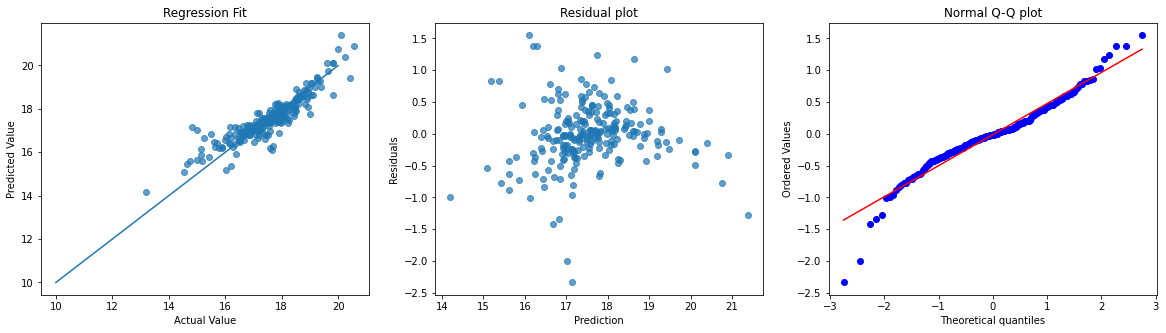

In [31]:
test_assumptions(X,y, 5)
#Everything looks good here

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .25, random_state = 21)

In [54]:
#final test of R**2 on our poly ridge model
alpha_poly_ri = 10**np.linspace(-2,2,200)
clf = RidgeCV(alphas=alpha_poly_ri, cv=5)
clf.fit(X_train,y_train)

clf.score(X_test,y_test)

0.653816745695938

In [60]:
#lets get a final score on all of our conditions
final_score = sm.OLS(y, X, data=movie_df)

final_res = final_score.fit()

final_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         dom_log_target   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     125.1
Date:                Thu, 30 Sep 2021   Prob (F-statistic):          9.59e-151
Time:                        23:14:56   Log-Likelihood:                -817.89
No. Observations:                 739   AIC:                             1658.
Df Residuals:                     728   BIC:                             1708.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
log_opening_w         0.6823      0.040     16.947      0.000       0.603       0.761
log_budget            0.2241      0.034      6.518      0.000       0.157       0.292
no_Theaters_open     -0.0003   5.96e-05     -5.495      0.000      -0.000      -0.000
Running_Time(min)     0.0074      0.002      4.072      0.000       0.004       0.011
G                     1.7600      0.487      3.616      0.000       0.805       2.715
PG                    1.3418      0.375      3.574      0.000       0.605       2.079
PG_13                 1.3060      0.382      3.423      0.001       0.557       2.055
R                     1.3012      0.369      3.527      0.000       0.577       2.025
winter                1.3751      0.380      3.619      0.000       0.629       2.121
spring                1.4056      0.380      3.696      0.000       0.659       2.152
summer                1.3553      0.379      3.575      0.000       0.611       2.100
fall_holiday          1.5729      0.382      4.118      0.000       0.823       2.323
==============================================================================
Omnibus:                      112.854   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              852.641
Skew:                          -0.430   Prob(JB):                    7.10e-186
Kurtosis:                       8.192   Cond. No.                     1.98e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.66e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""